# Immune-checkpoint blockade (ICB) data
### Farnoosh Babazadeh, Minoru Nakano, Sisira Kadambat Nair, and Benjamin Haibe-Kains 

This script shows preliminary analyses of downloaded ICB Braun dataset (PMID 32472114). The script is organized as follows:

1. Load Braun dataset
2. Clinical data summary
3. Logistic regression analysis 
4. Survival analysis
 * Kaplan-Meier (KM) and log-rank test
 * Cox proportional-hazards (PH) model using single gene
 * Cox proportional-hazards (PH) model using protein coding genes

## Load data

To download and extract TSV version of ICB data from Zenodo (https://zenodo.org/record/7058399/files/), follow the script named download_tsv_data.R file at "~/Code/Download_Data".  

As an example, we consider the ICB Braun data with PMID 32472114 and read RNA-seq expression, clinicopathological characteristics, and gene meta data. The Braun study includes 319 patients with clinical data and 40,994 genes. While only 181 patients have both clinical data and RNA-seq expression data. 

Note that the expression data is $log2(\text{TPM} + 0.001)$, where TPM represents transcripts per million. 


In [4]:
# importing libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


In [5]:
# clinicopathological characteristics  
dat_sample = pd.read_csv('ICB_Braun_metadata.tsv', sep='\t')

dat_sample.head()

,patientid,sex,age,cancer_type,histo,tissueid,treatmentid,stage,response.other.info,recist,...,TSC1,USP32,VHL,WNT8A,ZNF800,Angio,Teff,Myeloid,Javelin,Merck18
RCC_1,RCC_1,F,49.0,Kidney,NaN,Kidney,Nivolumab,NaN,NaN,PD,...,WT,WT,WT,WT,WT,NaN,NaN,NaN,NaN,NaN
RCC_10,RCC_10,F,64.0,Kidney,NaN,Kidney,Nivolumab,NaN,NaN,SD,...,WT,WT,MUT,WT,WT,NaN,NaN,NaN,NaN,NaN
RCC_102,RCC_102,F,64.0,Kidney,NaN,Kidney,Nivolumab,NaN,NaN,SD,...,WT,WT,WT,WT,WT,35.570275,30.038614,30.284130,30.142362,32.182083
RCC_105,RCC_105,F,64.0,Kidney,NaN,Kidney,Nivolumab,NaN,NaN,PD,...,WT,WT,WT,WT,WT,33.335166,27.763485,30.197198,28.120986,30.159456
RCC_106,RCC_106,F,61.0,Kidney,NaN,Kidney,Nivolumab,NaN,NaN,PR,...,WT,WT,MUT,WT,WT,35.629600,28.315512,29.686902,30.188104,31.707407


In [5]:
dat_sample.shape

(319, 145)

In [6]:
# gene meta data
dat_gene = pd.read_csv('ICB_Braun_expr_genes.tsv', sep='\t')

dat_gene.head()

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,gene_type,gene_name,level,havana_gene,tag,gene_id_no_ver,length
1,chr1,11869,14412,2544,+,HAVANA,gene,NaN,NaN,ENSG00000223972.4,pseudogene,DDX11L1,2,OTTHUMG00000000961.2,NaN,ENSG00000223972,NaN
2,chr1,135141,135895,755,-,HAVANA,gene,NaN,NaN,ENSG00000268903.1,pseudogene,RP11-34P13.15,2,OTTHUMG00000182518.2,NaN,ENSG00000268903,NaN
3,chr1,1631369,1633249,1881,+,HAVANA,gene,NaN,NaN,ENSG00000215914.3,pseudogene,MMP23A,2,OTTHUMG00000000585.5,NaN,ENSG00000215914,NaN
4,chr1,43803478,43818443,14966,+,HAVANA,gene,NaN,NaN,ENSG00000117400.10,protein_coding,MPL,2,OTTHUMG00000007429.1,NaN,ENSG00000117400,NaN
5,chr4,109571740,109588976,17237,+,HAVANA,gene,NaN,NaN,ENSG00000198856.8,protein_coding,OSTC,2,OTTHUMG00000161031.2,ncRNA_host,ENSG00000198856,NaN


In [7]:
dat_gene.shape

(40994, 17)

In [8]:
# RNA-seq expression data (i.e., log2(TPM + 0.001)) 
dat_exp = pd.read_csv('ICB_Braun_expr.tsv', sep='\t')

dat_exp.head()

,RCC25_677,RCC25_582,RCC25_678,RCC25_7,RCC25_624,RCC25_982,RCC25_646,RCC25_493,RCC25_272,RCC25_465,...,RCC_18,RCC_21,RCC_27,RCC_41,RCC_50,RCC_73,RCC_90,RCC_93,RCC_96,RCC_99
ENSG00000000003.10,30.505120,32.553160,32.559420,32.534370,30.768170,32.744900,32.283620,31.550420,31.454450,31.146140,...,33.116670,30.961900,31.670000,31.449420,30.950210,32.059140,33.429040,32.396100,30.768670,30.971060
ENSG00000000005.5,22.021540,27.112060,26.941130,21.361809,28.213150,28.688240,25.561920,23.579830,27.513790,24.469540,...,23.292870,23.292870,23.292870,23.292870,23.292870,30.296130,31.298470,23.292870,23.292870,23.292870
ENSG00000000419.8,34.620490,33.999030,35.022040,35.510050,34.629310,34.437100,34.701670,35.732630,34.384040,34.760230,...,34.797140,34.420790,33.762510,34.607440,33.603170,34.184280,36.150720,34.404340,34.374910,35.113900
ENSG00000000457.9,30.994360,31.052770,30.568370,31.312370,31.009620,30.926620,31.310410,32.473150,30.299040,30.832610,...,30.838030,31.657010,31.067290,30.794590,30.324540,30.136810,31.331730,30.423840,31.009190,30.777810
ENSG00000000460.12,32.840623,31.916146,30.487933,31.919557,32.130353,31.420439,32.864445,32.042597,30.932105,32.271196,...,29.839717,32.091262,31.540874,30.575225,31.542232,31.880173,32.646188,31.376367,32.155486,32.642099


In [9]:
dat_exp.shape

(40994, 181)

In [10]:
# Get the subset of data with both clinical and expression data.

dat_sample_subset = dat_sample.loc[dat_exp.columns.values.tolist(), ]
dat_sample_subset.shape


(181, 145)

## Clinical data summary

The detailed clinicopathological characteristics of the Braun cohort including cancer type, age, sex, respose, overall survival (OS), and progression-free survival (PFS). 

The summary table represents that in Braun study almost 22\% of ICB response data is missing and more than 80\% of patients are female.   



In [12]:
dat_sample_subset.agg(
    {
        "age": ["count","mean", "median", "std", "min", "max"],
        "survival_time_os": ["count", "mean", "median", "std", "min", "max"],
        "survival_time_pfs": ["count","mean", "median", "std", "min", "max"],
    }
)

,age,survival_time_os,survival_time_pfs
count,180.000000,181.000000,181.000000
mean,61.327778,28.519316,8.480699
median,62.000000,22.439425,3.712526
std,10.977799,21.475065,12.378719
min,30.000000,0.295688,0.032854
max,88.000000,73.150685,61.906849



In addition, we assess whether there is any association between the sex and response using the Chi-squared test. The result shows that sex and ICB response are not associated (p=0.99)


In [14]:
response_sex_class = pd.crosstab(index=dat_sample_subset["sex"], 
                         columns=dat_sample_subset["response"],
                             margins=True)  
response_sex_class

response,NR,R,All
sex,,,
F,85,33,118
M,18,6,24
All,103,39,142


In [16]:
# Chi-square test of independence.

c, p, dof, expected = chi2_contingency(response_sex_class)

round(p, 3)

0.999

## Logistic regression analysis

To assess the association between a gene and response (R vs. NR) variable, we fit the logistic regression model. The structural form of the logistic regression model is given as

$$\textit{logit}(E(Y|X)) = \textit{logit}(p) = \textit{ln} (\frac{p}{1-p}) = \beta_0 + \beta_1 X + \epsilon$$

* $Y$  denotes the outcome or dependent variable (e.g., ICB response); this is a binary variable
* $X$  denotes the predictor of interest or the independent variable (e.g., gene expression data)
* $p$ denotes the probability of the event occurring, and $\frac{p}{1-p}$ shows the odds ratio (OR)
* $\beta_0$ denotes the Y-intercept when X is zero; this is not informative for logistic regression models
* $\beta_1$ denotes the slope or the expected change in log odds per unit change in X
* $\epsilon$ denotes the errors

The logistic regression model has several assumptions such as observations are independent of each other, no multi-collinearity across independent variables, and linearity of log odds. 

For a given gene ENSG00000065491.8 (TBC1D22B), the boxplot shows the distribution of expression data across the ICB response where almost 22\% of ICB response is missing. 

After removing the missing values, the fitted logistic model demonstrates that TBC1D22B is associated with improved ICB response ($log\text{OR} = 0.98$ and $p = 0.003$).

In [18]:
# clean and prepare data
y = dat_sample_subset["response"]
x = dat_exp.transpose()

x_subset = x.loc[:, "ENSG00000065491.8"]

df = pd.DataFrame({'x': x_subset, 
        'y': dat_sample_subset["response"]}
)
df = df.dropna()

df["y"] = df["y"].map({"R": 0, "NR" : 1})

# fit logistic model

model_logit = smf.logit(formula="y ~ x", data=df)
res = model_logit.fit()

res.summary()


Optimization terminated successfully.
         Current function value: 0.553173
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  142
Model:                          Logit   Df Residuals:                      140
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                 0.05895
Time:                        13:59:09   Log-Likelihood:                -78.551
converged:                       True   LL-Null:                       -83.471
Covariance Type:            nonrobust   LLR p-value:                  0.001706
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.4300     10.116     -2.909      0.004     -49.256      -9.604
x              0.9834      0.328      3.001      0.003       0.341       1.626
==============================================================================
"""

In [19]:
res_df = {
             "gene_id": "ENSG00000065491.8",
             "logOR":round(res.params["x"], 4),
             "SE" : round(res.bse["x"], 4),
             "pval":round(res.pvalues["x"], 4)
                       }

res_df


{'gene_id': 'ENSG00000065491.8', 'logOR': 0.9834, 'SE': 0.3277, 'pval': 0.0027}

## Survival analysis

### Part I: Kaplan-Meier (KM) and log-rank test

We consider the Kaplan-Meier (KM) and log-rank test to assess the impact of sex (F vs. M) and ICB response (R vs. NR) on overall survival rate (OS). 

The KM plot and log-rank test shows that there is not any significant difference in survival rate across two group of sex (F vs. M) ($p = 0.11$). However, using the ICB response (R vs. NR) and OS data, there is considerable difference in survival rate across two group of response ($p < 0.0001$) 

Text(0.5, 1.0, 'Survival of different gender group')

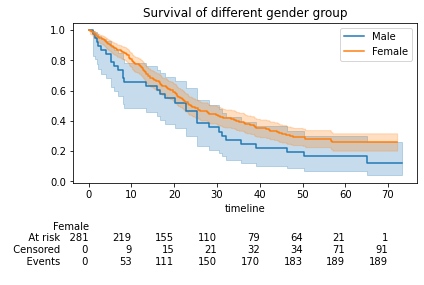

In [9]:
T = dat_sample["survival_time_os"]
E = dat_sample["event_occurred_os"]

ax = plt.subplot(111)

m = (dat_sample["sex"] == "M")
kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")


In [10]:
# log-rank test

ix = dat_sample['sex'] == 'F'
T_exp, E_exp = dat_sample.loc[ix, 'survival_time_os'], dat_sample.loc[ix, 'event_occurred_os']
T_con, E_con = dat_sample.loc[~ix, 'survival_time_os'], dat_sample.loc[~ix, 'event_occurred_os']


results = logrank_test(T_exp, T_con, 
                       event_observed_A=E_exp, 
                       event_observed_B=E_con)

results.print_summary()



C:\ProgramData\Anaconda3\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.78 0.10      3.39


We consider the KM and log-rank test to assess if there is any statistically difference in survival rate (e.g., OS) if we divide our data based on response (R vs. NR).

The log-rank test $p < 0.005$ shows there is considerable difference in survival rate across two group of response (R vs. NR).  


Text(0.5, 1.0, 'Survival of different gender group')

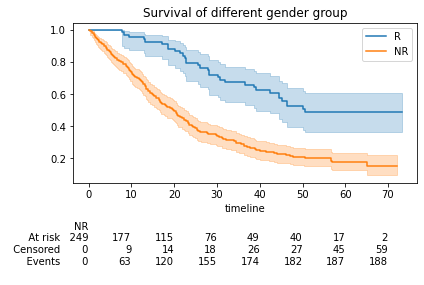

In [12]:
ax = plt.subplot(111)

m = (dat_sample["response"] == "R")
kmf.fit(durations = T[m], event_observed = E[m], label = "R")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "NR")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")

In [32]:
# log-rank test

ix = dat_sample['response'] == 'R'
T_exp, E_exp = dat_sample.loc[ix, 'survival_time_os'], dat_sample.loc[ix, 'event_occurred_os']
T_con, E_con = dat_sample.loc[~ix, 'survival_time_os'], dat_sample.loc[~ix, 'event_occurred_os']


results = logrank_test(T_exp, T_con, 
                       event_observed_A=E_exp, 
                       event_observed_B=E_con)

results.print_summary()


C:\ProgramData\Anaconda3\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          32.08 <0.005     26.01

### Part II: Cox proportional-hazards (PH) model using single gene

To assess the association between genes and time-to-event variables (e.g., OS), we fit the Cox proportional hazards model. The semi-parametric Cox PH model is given as 

$$h(t) = h_0(t) \times \text{exp}(\beta X)$$

where 

* $t$ represents the survival time.
* $h(t)$ is the hazard function determined by a set of covariate (e.g., X)
* The coefficient $\beta$ measures the impact of covariate.
* The term $h_0$ is called the baseline hazard. It corresponds to the value of the hazard if the covariate is equal to zero. The $t$ in $h(t)$ reminds us that the hazard may vary over time.
* The quantity $\text{e}^\beta$ is called hazard ratios (HR).


The fitted Cox model demonstrates that TBC1D22B is not associated with OS ($logHR = 0.08$, $p = 0.52$).


In [26]:
df = pd.DataFrame({
    'T': dat_sample_subset["survival_time_os"],
    'E': dat_sample_subset["event_occurred_os"],
    'exp': x_subset,
})

cph = CoxPHFitter()
cph_fit = cph.fit(df, duration_col = 'T', event_col= 'E')
cph.print_summary()



C:\ProgramData\Anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 181 total observations, 58 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 123
   partial log-likelihood = -565.32
         time fit was run = 2022-09-08 18:08:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
exp         0.08       1.09       0.13            -0.17             0.34                 0.84                 1.41

            cmp to    z    p   -log2(p)
covariate                              
exp           0.00 0.65 0.52       0.95
---
Concordance = 0.54
Partial AIC = 1132.64
log-likelihood ratio test = 0.42 on 1 df
-log2(p) of ll-ratio test = 0.95

In [28]:
res_df = {
             "gene_id": "ENSG00000065491.8",
             "logHR":round(cph.params_["exp"], 4),
             "SE" : round(cph.standard_errors_["exp"], 4)
                       }

res_df


{'gene_id': 'ENSG00000065491.8', 'logHR': 0.0845, 'SE': 0.131}